# [機械稼働音の異常検知](https://signate.jp/competitions/358)

## Refference

1 [音声ファイル前処理（データロード）](https://work-in-progress.hatenablog.com/entry/2020/02/16/112452)  
2 [「ToyADMOS:異常音検知」：AutoEncoder](https://note.com/toshi_sugi/n/nc4a5b9c4d6cf)  
3 [kaggle, Dectecting Anomaly using Autoencoder!](https://www.kaggle.com/code/ohseokkim/dectecting-anomaly-using-autoencoder)  
4 [stack overflow, how to set rmse cost function in tensorflow](https://stackoverflow.com/questions/33846069/how-to-set-rmse-cost-function-in-tensorflow)  
5 [回帰分析における評価指標　―①RMSE/MSE―](https://www.scsk.jp/sp/mwai/blog/cat/rmsemse.html)  
6 [損失関数とは](https://www.ibm.com/jp-ja/think/topics/loss-function)  

## Import modules

In [1]:
import os
import gc
import pathlib
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras import Model, layers, optimizers, callbacks
os.environ["KERAS_BACKEND"] = "tensorflow"

from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report

from IPython import display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Define Functions

ポイント
	•	STFT 後のフレーム数は
$$
\text{time\_frames}
= \left\lfloor\frac{(\text{wave\_length}) - \text{frame\_length}}{\text{frame\_step}}\right\rfloor + 1
$$
で決まります。  
  
•  この time_frames を 1024 に揃えたいので、波形長 (wave_length) を切り出し、上式が 1024 になるようにします。  
•  さらに、メルフィルタバンクの次元を 128 (num_mel_bins=128) に設定すれば、STFT の形状 (1024, n_fft_bin) → (1024, 128) に投影され、最終的に (1024, 128) の対数メルスペクトログラムになります。

例: フレーム長=512、フレームシフト=128 の場合
	•  フレーム数:
$$
\text{time\_frames} = \left\lfloor\frac{(\text{wave\_length}) - 512}{128}\right\rfloor + 1
$$
	•  これを 1024 にしたいので:
$$
\left\lfloor\frac{(\text{wave\_length}) - 512}{128}\right\rfloor + 1 = 1024
\quad\Longrightarrow\quad
\frac{(\text{wave\_length}) - 512}{128} = 1023
$$
$$
\quad\Longrightarrow\quad
\text{wave\_length} = 1023 \times 128 + 512 = 131456
$$
	•  つまり「波形長を 131,456 サンプルに揃える」と、STFT でちょうど 1024 フレームとなる。
	•  16kHz の波形長 131,456 サンプルは約 8.22 秒分。
	  （それより長い音声なら先頭の 131,456 サンプルだけ使い、短ければ 0 パディングして合わせる）。

In [2]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    return tf.squeeze(audio, axis=-1)  # shape=(num_samples,)

In [36]:
def compute_stats(dataset):
    """
    データセットから統計量（平均、標準偏差、最小値、最大値）を計算する関数
    入力:
        dataset: tf.data.Dataset（データセット）
    出力:
        stats: dict（平均、標準偏差、最小値、最大値を含む辞書）
    """
    mean = tf.constant(0.0)
    std = tf.constant(0.0)
    min_val = tf.constant(float('inf'))
    max_val = tf.constant(float('-inf'))
    count = tf.constant(0.0)  # countを初期化

    for batch in dataset:
        batch_mean = tf.reduce_mean(batch)
        batch_std = tf.math.reduce_std(batch)
        batch_min = tf.reduce_min(batch)
        batch_max = tf.reduce_max(batch)
        batch_count = tf.cast(tf.size(batch), tf.float32)  # バッチ内のサンプル数を計算

        # 統計量の更新
        mean += batch_mean * batch_count
        std += batch_std * batch_count
        min_val = tf.minimum(min_val, batch_min)
        max_val = tf.maximum(max_val, batch_max)
        count += batch_count  # バッチサイズを加算

    mean /= count
    std /= count

    stats = {
        "mean": mean.numpy(),  # NumPy形式に変換
        "std": std.numpy(),
        "min_val": min_val.numpy(),
        "max_val": max_val.numpy(),
    }
    return stats

In [24]:
def get_fixed_mel_spectrogram(
    waveform, 
    sample_rate=16000,
    desired_length=131456,
    frame_length=512,
    frame_step=128,
    num_mel_bins=128,
    do_standardize=False,
    do_normalize=False,
    stats=None
):
    """
    入力: 
        waveform: 1次元Tensor [num_samples] (float型, -1.0〜1.0想定)
        sample_rate: サンプリングレート(Hz)
        desired_length: time_frames=1024 を実現できるサンプル長
        frame_length, frame_step: STFTパラメータ
        num_mel_bins: メルフィルタバンクの次元
        do_standardize: True の場合、(値 - 平均)/標準偏差 の標準化を行う
        do_normalize  : True の場合、(値 - min)/(max - min) の正規化を行う
        stats: 標準化及び正規化のための統計量(平均、標準偏差、最大値、最小値) 
    出力: shape=(1024, num_mel_bins, 1) の Tensor (対数メルスペクトログラム)
    """
    eps = 1e-6

    waveform = waveform[:desired_length]
    pad_len = desired_length - tf.shape(waveform)[0]
    waveform = tf.pad(waveform, paddings=[[0, pad_len]])
    waveform = tf.cast(waveform, dtype=tf.float32)

    stft = tf.signal.stft(
        signals=waveform,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=frame_length
    )
    spectrogram = tf.square(tf.abs(stft))
    n_stft_bin = spectrogram.shape[-1]
    mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=n_stft_bin,
        sample_rate=sample_rate,
        lower_edge_hertz=0.0,
        upper_edge_hertz=sample_rate / 2.0
    )
    mel_spectrogram = tf.tensordot(spectrogram, mel_filterbank, axes=1)

    log_mel_spectrogram = tf.math.log(mel_spectrogram + eps)

    if do_standardize and stats is not None:
        log_mel_spectrogram = (log_mel_spectrogram - stats["mean"]) / (stats["std"] + eps)

    if do_normalize and stats is not None:
        log_mel_spectrogram = (log_mel_spectrogram - stats["min_val"]) / (stats["max_val"] - stats["min_val"] + eps)

    log_mel_spectrogram = tf.expand_dims(log_mel_spectrogram, axis=-1)
    return log_mel_spectrogram

In [22]:
def load_and_preprocess(file_path, 
                        do_standardize=False,
                        do_normalize=False,
                        stats=None):
    """
    ファイルパスを受け取り、波形をロードし、メルスペクトログラムを生成する関数。
    標準化や正規化を行う際に、統計量(stats)を使用する。
    """
    # Waveform load
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)  # shape=(num_samples,)
    waveform = tf.cast(waveform, dtype=tf.float32)
    
    # メルスペクトログラム(1024, 128, 1)に変換
    log_mel_spec = get_fixed_mel_spectrogram(
        waveform=waveform,
        do_standardize=do_standardize,
        do_normalize=do_normalize
    )

    return log_mel_spec  # shape=(1024, 128, 1)

In [25]:
def create_dataset(file_list, batch_size=8, stats=None, do_standardize=False, do_normalize=False):
    
    if do_standardize and do_normalize:
        raise ValueError("Both standardize and normalize cannot be True at the same time.")
    
    ds = tf.data.Dataset.from_tensor_slices(file_list)
    ds = ds.map(
        lambda fname: load_and_preprocess(
            fname,
            do_standardize=do_standardize,
            do_normalize=do_normalize,
            stats=stats
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

## Define Auto Encoder Class

**注意**
- 標準化（standardize=True)のときはデコーダの出力層の活性関数を"linear"かNoneにする。
- 正規化（normalize=True)のときはデコーダの出力層の活性関数を"sigmoid"にする。

In [26]:
class Autoencoder(Model):
  def __init__(self, input_shape=(1024, 128, 1),
                resized_shape=(256, 64)):
      super(Autoencoder, self).__init__()

      # === Resizing レイヤー ===
      self.resizer = layers.Resizing(
          height=resized_shape[0],
          width=resized_shape[1],
          interpolation='bicubic'
      )
      
      # === Encoder ===
      self.encoder = tf.keras.Sequential([
          # Conv2D(128) + Pool
          layers.Conv2D(128, (3,3), padding='same', activation='leaky_relu',
                        input_shape=(resized_shape[0], resized_shape[1], 1)),
          layers.MaxPooling2D(pool_size=(2,2), padding='same'),
          layers.BatchNormalization(),
          
          # Conv2D(64) + Pool
          layers.Conv2D(64, (3,3), padding='same', activation='leaky_relu'),
          layers.MaxPooling2D(pool_size=(2,2), padding='same'),
          layers.BatchNormalization(),
          
          # Conv2D(32) + Pool
          layers.Conv2D(32, (3,3), padding='same', activation='leaky_relu'),
          layers.MaxPooling2D(pool_size=(2,2), padding='same'),
          layers.BatchNormalization(),
          
          # Conv2D(16) + Pool
          # ここでは sigmoid を外しておく
          layers.Conv2D(16, (3,3), padding='same', activation='leaky_relu'),
          layers.MaxPooling2D(pool_size=(2,2), padding='same'),
          layers.BatchNormalization(),
      ])
      
      # === Decoder ===
      self.decoder = tf.keras.Sequential([
          layers.Conv2D(16, (3,3), padding='same', activation='leaky_relu'),
          layers.UpSampling2D((2,2)),
          layers.BatchNormalization(),
          
          layers.Conv2D(32, (3,3), padding='same', activation='leaky_relu'),
          layers.UpSampling2D((2,2)),
          layers.BatchNormalization(),
          
          layers.Conv2D(64, (3,3), padding='same', activation='leaky_relu'),
          layers.UpSampling2D((2,2)),
          layers.BatchNormalization(),
          
          layers.Conv2D(128, (3,3), padding='same', activation='leaky_relu'),
          layers.UpSampling2D((2,2)),
          layers.BatchNormalization(),
          
          # ここで (256,64)->(1024,128) に拡大
          layers.UpSampling2D((4,2)),
          # 最終Conv
          layers.Conv2D(1, (3,3), padding='same', activation='linear'),
      ])

  def call(self, x):
      # x: shape = (batch, 1024, 128, 1)
      x_small = self.resizer(x)  # → (batch, 256, 64, 1)
      encoded = self.encoder(x_small)
      decoded = self.decoder(encoded)
      return decoded

## Read Audio(.wav) Data

### Train Notmal

In [32]:
# オーディオクリップをfilenamesというリストに抽出します
filenames = glob.glob('../01_input/wav/train_normal/dummy/*.wav')
num_samples = len(filenames)
filenames.sort()
print('Number of total examples:', num_samples)
print('Example file tensor:', filenames[0])

Number of total examples: 300
Example file tensor: ../01_input/wav/train_normal/dummy/000.wav


In [28]:
# オーディオファイルの形状を確認
train_file = tf.io.read_file(filenames[0])
train_audio, sampling_rate = tf.audio.decode_wav(contents=train_file)

In [29]:
# Audio Setting
Data_num = train_audio.shape[0]
Sampling_freq = sampling_rate.numpy()
time_length = Data_num / Sampling_freq

print("Data数：", Data_num)
print("サンプリング周波数[Hz]：", Sampling_freq)
print("時間窓長[sec]:", time_length)
print("分析周波数レンジ[Hz]:", Sampling_freq // 2)

Data数： 160000
サンプリング周波数[Hz]： 16000
時間窓長[sec]: 10.0
分析周波数レンジ[Hz]: 8000


In [33]:
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(filenames, test_size=0.2, random_state=42)

In [37]:
## 統計量の計算
train_ds_raw = create_dataset(train_files, batch_size=8, stats=None, do_standardize=False, do_normalize=False)
stats = compute_stats(train_ds_raw)

# 統計量を用いた標準化
train_ds = create_dataset(train_files, batch_size=8, stats=stats, do_standardize=True, do_normalize=False)
val_ds = create_dataset(val_files, batch_size=8, stats=stats, do_standardize=True, do_normalize=False)

2025-01-06 01:52:13.441860: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [38]:
# OK例
for x in train_ds.take(1):  # 最初の1バッチだけ形状を確かめる
    print(x.shape)

(8, 1024, 128, 1)


2025-01-06 01:52:19.012502: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [39]:
autoencoder = Autoencoder()
adam_low_rate = optimizers.Adam(learning_rate=1e-3)
autoencoder.compile(optimizer=adam_low_rate, loss='mse')

/Volumes/HD-ADU3/Programming/Python/08_機械稼働音の異常検知/tf-metal/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
# 例: 現在 train_ds は単に (メルスペクトログラム) だけを返していると想定
# それを (x, x) 形式に変換
train_ds = train_ds.map(lambda x: (x, x))
val_ds = val_ds.map(lambda x: (x, x))

In [41]:
%%time

# オートエンコーダは正常の オーディオファイル のみを使用してトレーニング、
# 完全なテストセットを使用して評価されることに注意。
import datetime

time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#Training the model
es_callback = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

ckpt_filepath = f'../04_model/ckpt'+time+'/checkpoint-{epoch:03d}-{val_loss:.4f}.keras'
cp_callback = callbacks.ModelCheckpoint(filepath = ckpt_filepath, 
                                        monitor = 'val_loss',
                                        mode = 'auto',
                                        save_freq="epoch",
                                        save_best_only = True)
EPOCHS = 100
history = autoencoder.fit(
                        train_ds,
                        epochs=EPOCHS,
                        shuffle=True,
                        validation_data=val_ds,
                        callbacks=[es_callback, cp_callback]
                        )

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - loss: 23.6034 - val_loss: 17.4207
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 15.6445 - val_loss: 5.9785
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - loss: 4.0532 - val_loss: 1.7100
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - loss: 1.5039 - val_loss: 1.4285
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - loss: 1.3676 - val_loss: 1.3265
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - loss: 1.2793 - val_loss: 1.3184
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - loss: 1.2566 - val_loss: 1.2969
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - loss: 1.2229 - val_loss: 1.2055
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - loss: 1.1749 - val_loss: 1.1953
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - loss: 1.1634 - val_loss: 1.1885
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - loss: 1.1524 - val_loss: 1.1444
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - loss: 

In [42]:
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 256, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 16, 4, 16)      │        99,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1024, 128, 1)   │       101,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 599,717 (2.29 MB)

 Trainable params: 199,585 (779.63 KB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 399,172 (1.52 MB)

In [43]:
autoencoder.save( '../04_model/autoencoder_mel_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"+".keras"))

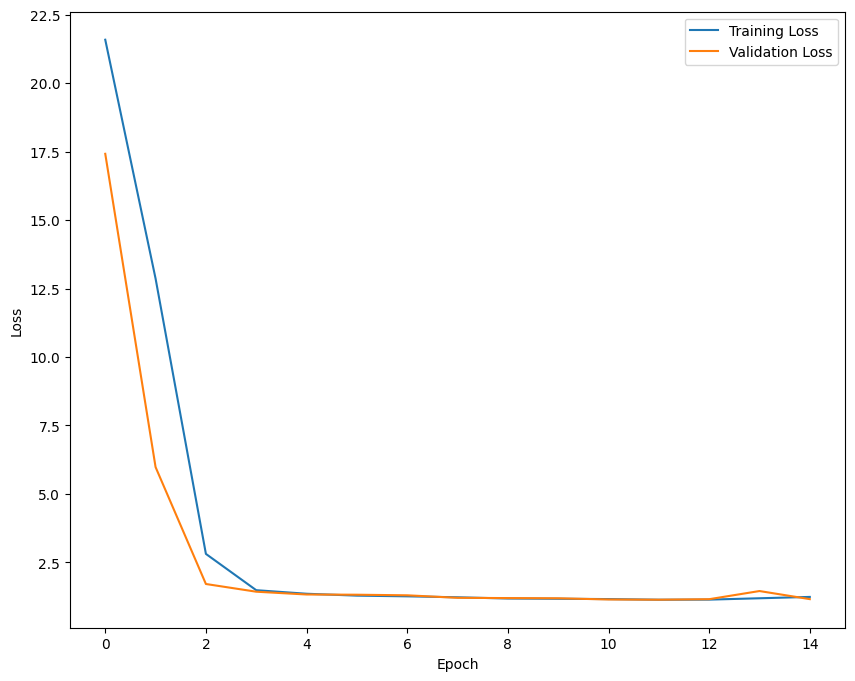

In [44]:
fig = plt.figure(figsize=(10, 8))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [45]:
def plot_spectrogram(spec, title='Spectrogram'):
    """
    spec: 2次元のnumpy配列 (time, freq) の想定。
          ここでは対数メルスペクトログラム (log scale) を想定。
    """
    plt.imshow(spec.T, origin='lower', aspect='auto', cmap='jet')
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()

def show_reconstruction(autoencoder, dataset, n=1):
    """
    autoencoder: 学習済みオートエンコーダ (入力shape = (batch, time, freq, 1))
    dataset: tf.data.Dataset or list/ndarray, shape=(batch, time, freq, 1)
    n: 表示したいサンプル数
    """

    # 1) データから1バッチ取り出す
    #    Datasetの場合は .take(1) で最初のバッチだけ
    for x_batch, _ in dataset.take(1):  # オートエンコーダなら (x, x) のペア想定
        # x_batch.shape = (batch_size, time, freq, 1)
        # 2) モデルに通して再構築を得る
        decoded_batch = autoencoder(x_batch, training=False)
        
        # TensorFlow tensor → numpy
        x_batch_np = x_batch.numpy()
        decoded_batch_np = decoded_batch.numpy()
        
        # 3) n 件だけ取り出して描画
        for i in range(n):
            # 入力スペクトログラム
            input_spec = x_batch_np[i, :, :, 0]    # shape=(time, freq)
            # 再構築されたスペクトログラム
            recon_spec = decoded_batch_np[i, :, :, 0]  # shape=(time, freq)
            
            plt.figure(figsize=(10,4))
            
            # 左: 入力
            plt.subplot(1,2,1)
            plot_spectrogram(input_spec, title='Input log-mel spectrogram')
            
            # 右: 再構築
            plt.subplot(1,2,2)
            plot_spectrogram(recon_spec, title='Reconstructed log-mel spectrogram')

            plt.show()
        break  # 1バッチだけ処理して終了

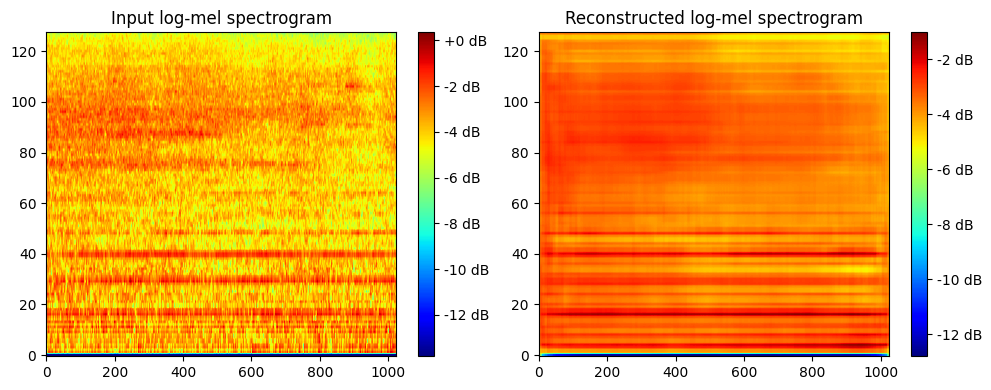

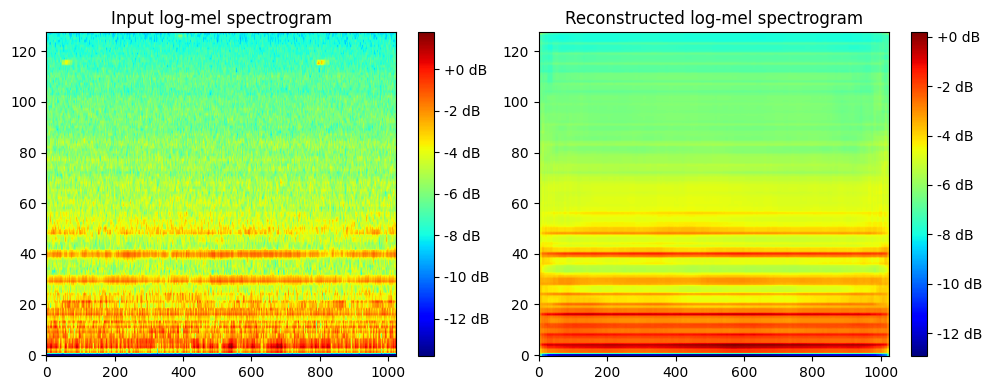

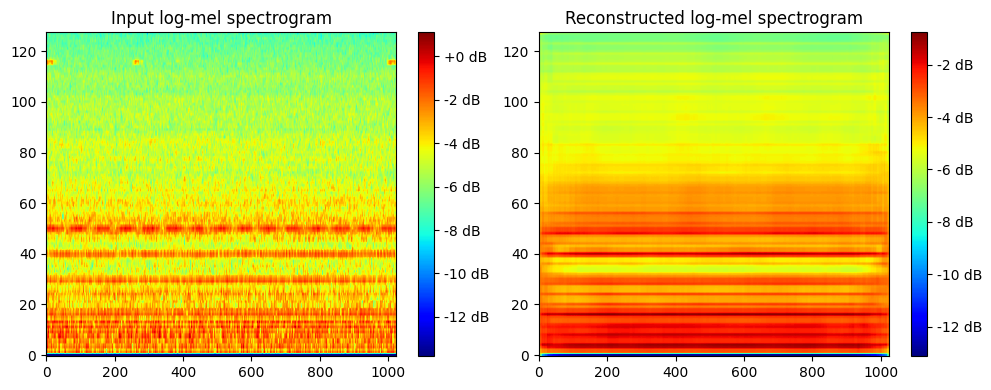

In [46]:
# 例: 最初の3サンプルを比較表示
show_reconstruction(autoencoder, train_ds, n=3)

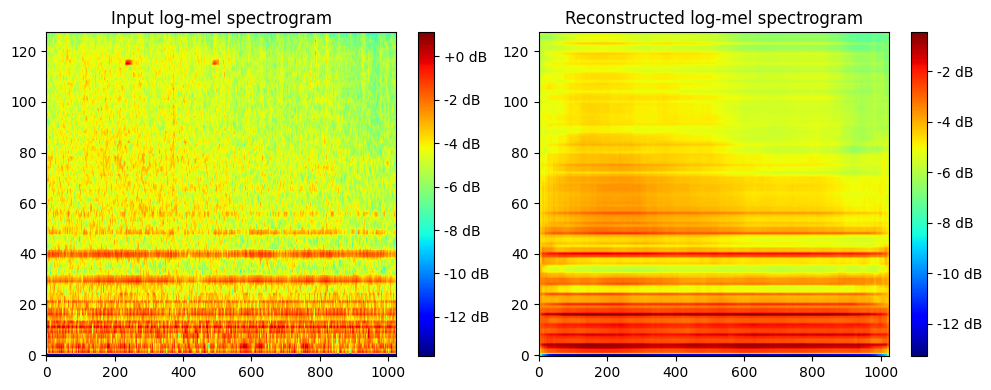

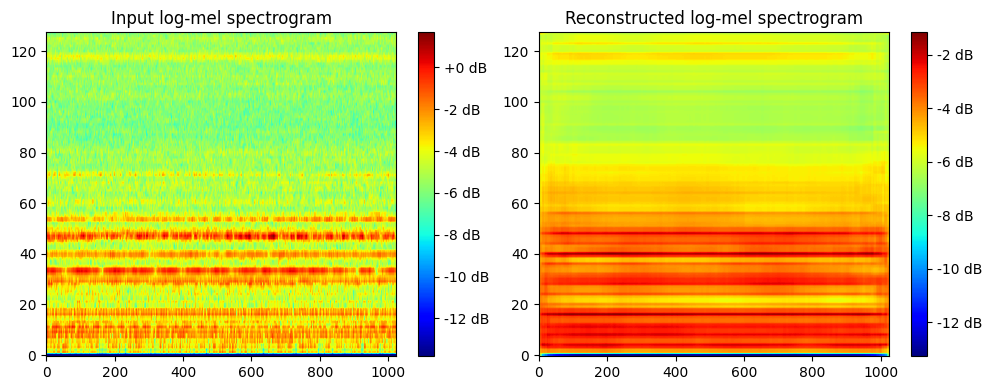

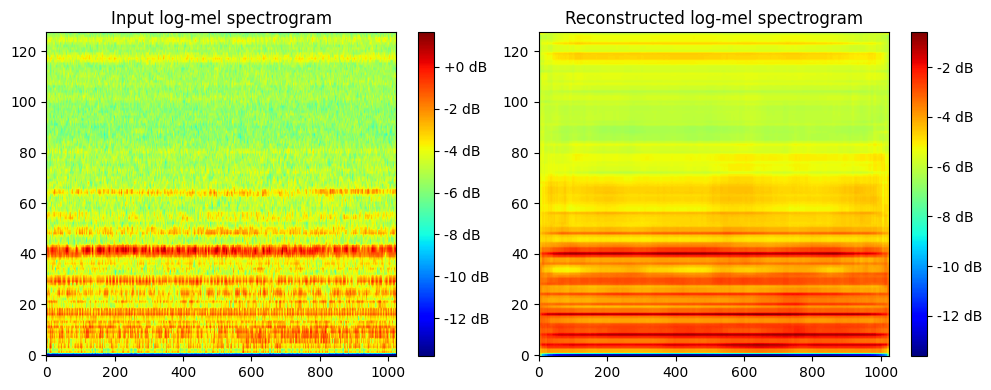

In [47]:
# 例: 最初の3サンプルを比較表示
show_reconstruction(autoencoder, val_ds, n=3)

### Valid Notmal

In [48]:
# オーディオクリップをfilenamesというリストに抽出します
filenames = glob.glob('../01_input/wav/valid_normal/dummy/*.wav')
num_samples = len(filenames)
filenames.sort()
print('Number of total examples:', num_samples)
print('Example file tensor:', filenames[0])

Number of total examples: 150
Example file tensor: ../01_input/wav/valid_normal/dummy/000.wav


In [50]:
val_normal_ds = create_dataset(filenames, batch_size=8, do_standardize=True, do_normalize=False)
val_normal_ds_raw  = create_dataset(filenames, batch_size=8, do_standardize=False, do_normalize=False)
val_normal_ds = val_normal_ds.map(lambda x: (x, x))

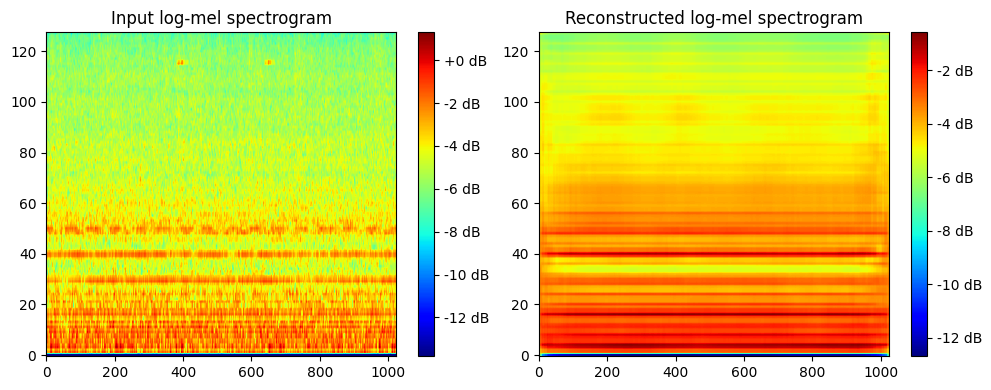

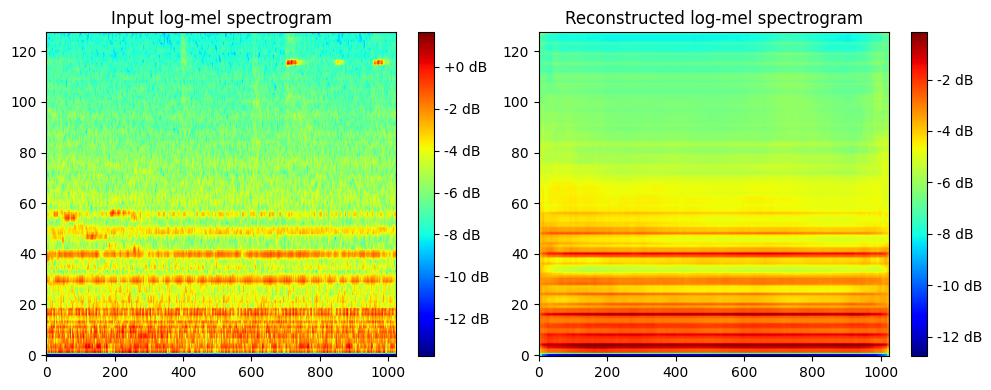

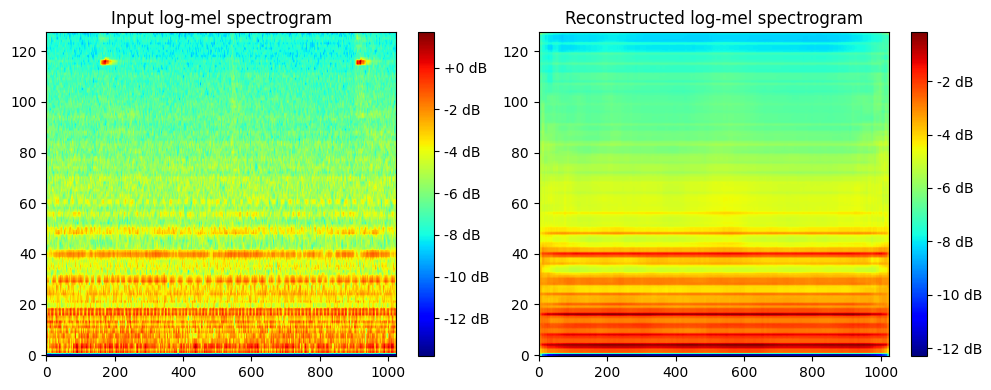

In [51]:
# 例: 最初の3サンプルを比較表示
show_reconstruction(autoencoder, val_normal_ds, n=3)

### Valid_Anomaly

In [52]:
def compute_stats(dataset):
    """
    正常データセットの統計量を計算
    入力:
        dataset (tf.data.Dataset): 正常データセット
    出力:
        stats (dict): mean, std, min_val, max_val を含む辞書
    """
    all_data = []
    for x, _ in dataset:  # x: (batch, height, width, channels)
        all_data.append(x.numpy())
    all_data = np.concatenate(all_data, axis=0)  # shape=(total_samples, height, width, channels)
    
    stats = {
        "mean": np.mean(all_data, axis=0),
        "std": np.std(all_data, axis=0),
        "min_val": np.min(all_data, axis=0),
        "max_val": np.max(all_data, axis=0),
    }
    return stats

In [53]:
def process_data(x, stats, standardize=False, normalize=False):
    """
    入力データを標準化または正規化
    入力:
        x (tf.Tensor): 入力データ
        stats (dict): 正常データの統計量 (mean, std, min_val, max_val)
        standardize (bool): True の場合、標準化を適用
        normalize (bool): True の場合、正規化を適用
    出力:
        processed_data (tf.Tensor): 標準化または正規化されたデータ
    """
    if standardize:
        mean, std = stats["mean"], stats["std"]
        x = (x - mean) / (std + 1e-6)  # 標準化
    if normalize:
        min_val, max_val = stats["min_val"], stats["max_val"]
        x = (x - min_val) / (max_val - min_val + 1e-6)  # 正規化
    return x

In [54]:
def preprocess_dataset(dataset, stats, standardize=False, normalize=False):
    """
    データセットに標準化または正規化を適用
    入力:
        dataset (tf.data.Dataset): 入力データセット
        stats (dict): 正常データの統計量
        standardize (bool): True の場合、標準化を適用
        normalize (bool): True の場合、正規化を適用
    出力:
        processed_dataset (tf.data.Dataset): 処理済みデータセット
    """
    return dataset.map(
        lambda x, _: (process_data(x, stats, standardize=standardize, normalize=normalize), _),
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [55]:
# オーディオクリップをfilenamesというリストに抽出します
filenames = glob.glob('../01_input/wav/valid_anomaly/dummy/*.wav')
num_samples = len(filenames)
filenames.sort()
print('Number of total examples:', num_samples)
print('Example file tensor:', filenames[0])

Number of total examples: 50
Example file tensor: ../01_input/wav/valid_anomaly/dummy/000.wav


In [56]:
val_normal_ds_raw = val_normal_ds_raw.map(lambda x: (x, x))
stats = compute_stats(val_normal_ds_raw)

In [57]:
val_anomaly_ds = create_dataset(filenames, batch_size=8)
val_anomaly_ds = val_anomaly_ds.map(lambda x: (x, x))
val_anomaly_ds_  = preprocess_dataset(val_anomaly_ds, stats, standardize=True, normalize=False)

In [58]:
for x, _ in val_anomaly_ds.take(1):
    print("Anomaly data range:", tf.reduce_min(x).numpy(), tf.reduce_max(x).numpy())

Anomaly data range: -13.815511 1.431861


2025-01-06 07:12:13.398534: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


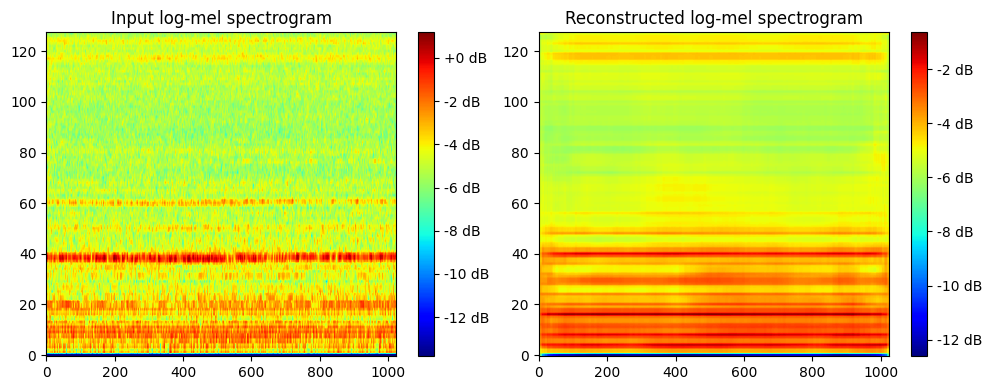

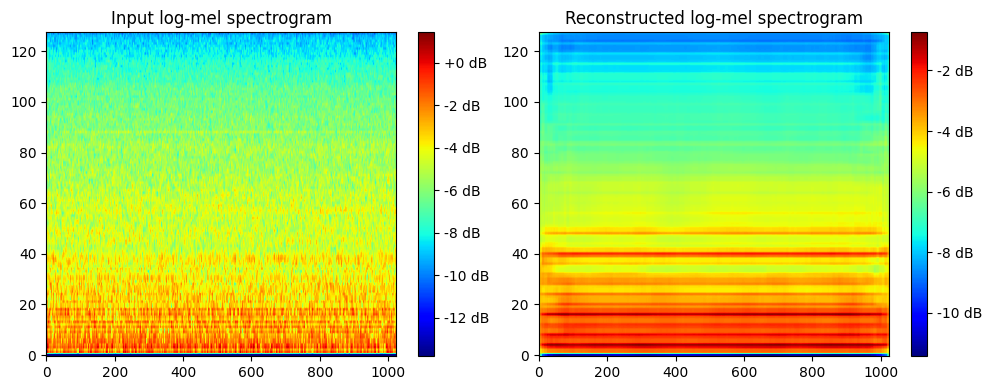

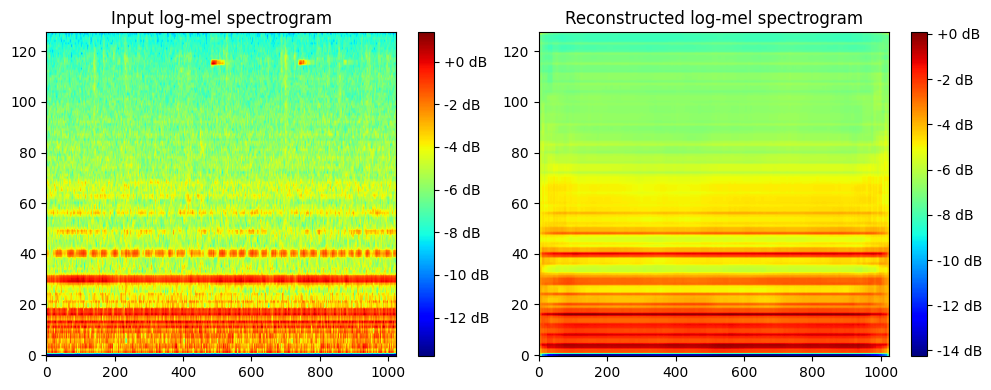

In [59]:
# 例: 最初の3サンプルを比較表示
show_reconstruction(autoencoder, val_anomaly_ds, n=3)

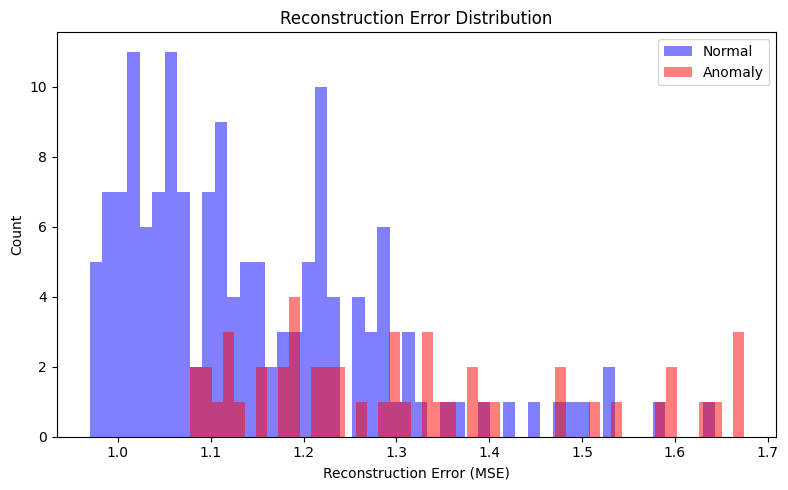

In [60]:
def compute_recon_errors(autoencoder, dataset):
    """
    dataset: (x, x) のタプルを返す tf.data.Dataset
    戻り値: 再構成誤差の1次元リスト (python listまたはnp.array)
    """
    all_errors = []
    for x_batch, _ in dataset:
        decoded = autoencoder(x_batch, training=False)
        # MSE計算
        errors = tf.reduce_mean(tf.square(x_batch - decoded), axis=[1,2,3])
        all_errors.extend(errors.numpy())  # python listに追加
    return np.array(all_errors)


def plot_error_histogram(normal_errors, anomaly_errors):
    """
    normal_errors: 正常データの誤差配列 (np.array)
    anomaly_errors: 異常データの誤差配列 (np.array)
    """
    plt.figure(figsize=(8,5))

    # 正常データのヒストグラム
    plt.hist(
        normal_errors, 
        bins=50, 
        alpha=0.5, 
        label="Normal",
        color='blue'
    )
    # 異常データのヒストグラム
    plt.hist(
        anomaly_errors, 
        bins=50, 
        alpha=0.5, 
        label="Anomaly",
        color='red'
    )
    
    plt.xlabel("Reconstruction Error (MSE)")
    plt.ylabel("Count")
    plt.legend()
    plt.title("Reconstruction Error Distribution")
    plt.tight_layout()
    plt.show()


# ===== 実際の流れ（例） =====

# 1) 正常データセット (normal_ds), 異常データセット (anomaly_ds) を作る
# 例:
# normal_ds  = create_dataset(normal_files,  batch_size=8) 
# anomaly_ds = create_dataset(anomaly_files, batch_size=8)
# ↑ それぞれ (x, x) のタプルを返すことを想定

# 2) 学習済みオートエンコーダ
# autoencoder = ...

# 3) 誤差計算
normal_errors  = compute_recon_errors(autoencoder, val_normal_ds)
anomaly_errors = compute_recon_errors(autoencoder, val_anomaly_ds)

# 4) ヒストグラム描画
plot_error_histogram(normal_errors, anomaly_errors)

In [61]:
# 平均＋標準偏差をしきい値とします。
threshold = np.mean(normal_errors) + np.std(normal_errors)*2
print("Mean: ", np.mean(normal_errors))
print("Std:  ", np.std(normal_errors))
print("Threshold: ", threshold)

Mean:  1.1457767
Std:   0.13700818
Threshold:  1.4197931


---

### Validation

In [ ]:
# テストセットの異常なサンプルの再構成エラーを調べます。
# しきい値を変更することで、分類器の精度とリコールを調整できます。

#reconstructions = autoencoder.predict(valid_normal_ds)
#test_loss_no = tf.keras.losses.mae(reconstructions, valid_normal_ds)
#reconstructions = autoencoder.predict(valid_anomaly_ds)
#test_loss_ab = tf.keras.losses.mae(reconstructions, valid_anomaly_ds)

#threshold = (threshold_nor + threshold_ano) / 2
threshold = threshold_nor

reconstructions = tf.cast(autoencoder.predict(valid_normal_ds), tf.float32)
test_loss_no = tf.sqrt(tf.reduce_mean((valid_normal_ds - reconstructions)**2, 1))
#test_loss_no = tf.keras.losses.mse(reconstructions, valid_normal_ds)

reconstructions = tf.cast(autoencoder.predict(valid_anomaly_ds), tf.float32)
test_loss_ab = tf.sqrt(tf.reduce_mean((valid_anomaly_ds - reconstructions)**2, 1))
#test_loss_ab = tf.keras.losses.mse(reconstructions, valid_anomaly_ds)


fig = plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.histplot(test_loss_no, bins=50, kde=True, linewidth=3)
#plt.vlines(threshold_nor, 0, 20, 'g', 'dashed')
#plt.vlines(threshold_ano, 0, 20, 'r', 'dashed')
plt.vlines(threshold, 0, 20, 'gray', 'dashed')
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.title("Normal data of Testset")

plt.subplot(1,2,2)
sns.histplot(test_loss_ab, bins=50, kde=True, linewidth=3)
#plt.vlines(threshold_nor, 0, 20, 'g', 'dashed')
#plt.vlines(threshold_ano, 0, 20, 'r', 'dashed')
plt.vlines(threshold, 0, 20, 'gray', 'dashed')
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.title("Anomalous data of Testset")
plt.show()

In [ ]:
plt.figure(figsize=(16,6))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(test_loss_no ,bins=50,kde=True,color='grey',linewidth=3)
plt.axvline(x=np.mean(test_loss_no), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss_no), 12, "Normal Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.text(threshold, 15, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')

sns.histplot(test_loss_ab ,bins=50,kde=True,color='red',linewidth=3)
plt.axvline(x=np.mean(test_loss_ab), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss_ab), 9, "Anomaly Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.xlabel("loss")
plt.ylabel("No of examples")
sns.despine()

In [ ]:
y_pred_normal = predict_rmse(autoencoder, valid_normal_ds, threshold).numpy()
#y_pred_normal = predict_mse(autoencoder, valid_normal_ds, threshold).numpy()
y_real_normal = np.full(y_pred_normal.shape, False)
print(classification_report(y_real_normal, y_pred_normal))

In [ ]:
sns.heatmap(confusion_matrix(y_real_normal, y_pred_normal), annot=True, fmt='d', cbar=False)

In [ ]:
y_pred_anomaly = predict_rmse(autoencoder, valid_anomaly_ds, threshold)
#y_pred_anomaly = predict_mse(autoencoder, valid_anomaly_ds, threshold)
y_real_anomaly = np.full(y_pred_anomaly.shape, True)
print(classification_report(y_real_anomaly, y_pred_anomaly))

In [ ]:
sns.heatmap(confusion_matrix(y_real_anomaly, y_pred_anomaly), annot=True, fmt='d',  cbar=False)

In [ ]:
y_pred = np.concatenate([y_pred_normal, y_pred_anomaly])
y_real = np.concatenate([y_real_normal, y_real_anomaly])
print("threadsold: ", threshold)
print(classification_report(y_real, y_pred))

####################################################################
reconstructions = tf.cast(autoencoder.predict(valid_normal_ds), tf.float32)
#loss_no = tf.sqrt(tf.reduce_mean((valid_normal_ds - reconstructions)**2, 1))
loss_no = tf.keras.losses.mse(reconstructions, valid_normal_ds)
reconstructions = tf.cast(autoencoder.predict(valid_anomaly_ds), tf.float32)
#loss_ab = tf.sqrt(tf.reduce_mean((valid_anomaly_ds - reconstructions)**2, 1))
loss_ab = tf.keras.losses.mse(reconstructions, valid_anomaly_ds)

loss = np.concatenate([loss_no, loss_ab])

fpr, tpr, thresholds = roc_curve(y_real, loss, pos_label=1)
youden_indices = tpr-fpr
index = np.argmax(tpr - fpr)
youden_cutoff = thresholds[index]
print("youden_cutoff: ",youden_cutoff)

print("Thredshold is Youden's Index.")
y_pred_normal_ = predict_mse(autoencoder, valid_normal_ds, youden_cutoff).numpy()
y_pred_anomaly_ = predict_mse(autoencoder, valid_anomaly_ds, youden_cutoff).numpy()
y_pred_ = np.concatenate([y_pred_normal_, y_pred_anomaly_])

print(classification_report(y_real, y_pred_))

In [ ]:
sns.heatmap(confusion_matrix(y_real, y_pred), annot=True, fmt='d')

In [ ]:
# Youden Index
sns.heatmap(confusion_matrix(y_real, y_pred_), annot=True, fmt='d')

In [ ]:
fpr, tpr, th = roc_curve(y_real, y_pred, drop_intermediate=False)
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

In [ ]:
print(roc_auc_score(y_real, y_pred))

In [ ]:
# Youden Index
fpr, tpr, th = roc_curve(y_real, y_pred_, drop_intermediate=False)
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

In [ ]:
print(roc_auc_score(y_real, y_pred_))

## To Output Submitting CSV

In [139]:
ans = pd.read_csv("../01_input/sample_submit.csv",  header=None)

In [ ]:
ans

In [ ]:
# オーディオクリップをfilenamesというリストに抽出します
filenames = glob.glob('../01_input/wav/test/dummy/*.wav')
num_samples = len(filenames)
filenames.sort()
print('Number of total examples:', num_samples)
print('Example file tensor:', filenames[0])

In [ ]:
# Audio Setting
Data_num = valid_normal_audio.shape[0]
Sampling_freq = valid_normal_sampling_rate.numpy()
time_length = Data_num / Sampling_freq

print("Data数：", Data_num)
print("サンプリング周波数[Hz]：", Sampling_freq)
print("時間窓長[sec]:", time_length)
print("分析周波数レンジ[Hz]:", Sampling_freq / 2)

In [143]:
AUTOTUNE = tf.data.AUTOTUNE
test_ds = tf.data.Dataset.from_tensor_slices(filenames)

waveform_ds = test_ds.map(
    map_func=get_waveform,
    num_parallel_calls=AUTOTUNE) # トレーニングセット作成

In [ ]:
for waveform in waveform_ds.take(1):
  #label = label.numpy().decode('utf-8')
  # spectrogram = get_spectrogram(waveform)
  fft = get_fft(waveform)

#print('Label:', label)
print('Waveform shape:', waveform.shape)
#print('Spectrogram shape:', spectrogram.shape)
print('FFT shape:', fft.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=Sampling_freq))

In [ ]:

# 時間波形と周波数波形をプロット
timescale = np.arange(Data_num) #len(waveform)
timescale = timescale/Sampling_freq

freq = np.arange(Data_num//2) * Sampling_freq / Data_num

fig, axes = plt.subplots(2, figsize=(15, 20))

axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, Data_num/Sampling_freq]) # [0, Data_num]
axes[0].set_xlabel("time[sec]")
axes[0].grid()

#axes[1].plot(freq/1000, fft)
axes[1].plot(fft)
axes[1].set_title('FFT')
axes[1].set_xlabel("frequency[kHz]")
axes[1].set_ylabel("[dB]")
axes[1].grid()
plt.show()

In [146]:
# 各データリストをFFTへ変換
test_ds = preprocess_dataset(filenames)
test_ds = list(test_ds)

In [147]:
# FFTの値を[0,1]の範囲へnormarization
min_val = tf.reduce_min(test_ds) # trainデータセットの最小値取得
max_val = tf.reduce_max(test_ds) # trainデータセットの最大値取得

test_ds = (test_ds - min_val) / (max_val - min_val) # [0,1]へ正規化
test_ds = tf.cast(test_ds, tf.float32) # 型の変換

In [ ]:
input_shape = valid_anomaly_ds.shape
input_shape = input_shape[1]
print('Input shape:', input_shape)

In [ ]:
# 試験サンプル

decoded_data = autoencoder(test_ds).numpy()

fig = plt.figure(figsize=(10, 8))

i:int  = 3

plt.plot(test_ds[i], 'b')
plt.plot(decoded_data[i], 'r')
plt.fill_between(np.arange(input_shape), decoded_data[i], test_ds[i], color='lightcoral') #
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.xlabel('frequency[Hz]')
plt.show()
print(f'loss of No.{i}: ', rmse(test_ds[i], decoded_data[i]).numpy())
#print(f'loss of No.{i}: ', tf.losses.mse(test_ds[i], decoded_data[i]).numpy())

In [ ]:
reconstructions = tf.cast(autoencoder.predict(test_ds), tf.float32)
loss = tf.sqrt(tf.reduce_mean((test_ds - reconstructions)**2, 1))
#loss = tf.keras.losses.mse(test_ds, reconstructions)

threshold = np.mean(loss) + np.std(loss)
#threshold_1 = np.mean(loss) + np.std(loss)
#threshold_2 = np.mean(loss) - np.std(loss)
#threshold = youden_cutoff
print("Mean: ", np.mean(loss))
print("Std : ", np.std(loss))
print("Threshold:", threshold)
#print("Threshold of 2 :", threshold_2)
#print("Threshold :", threshold)

In [ ]:
fig = plt.figure(figsize=(10, 8))

sns.histplot(loss, bins=50, kde=True, linewidth=3)
plt.xlabel("test loss")
plt.ylabel("No of examples")
'''
plt.axvline(x=threshold_2, color='r', linestyle='--', linewidth=3)
plt.text(threshold_2, 15, "Threshold of 2", horizontalalignment='center', 
         size='small', color='Red', weight='semibold')
'''
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.text(threshold, 15, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')

plt.axvline(x=np.mean(loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(loss), 12, "Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')

plt.show()

In [152]:
y_pred = predict_rmse(autoencoder, test_ds, threshold).numpy()

In [ ]:
ans[1] = y_pred * 1
ans

In [154]:
ans.to_csv(path_or_buf = "../05_submit/submission.csv", index=False, header=None)